In [10]:
"""
Exploratory Analysis - Step 1
Objective: Establish a baseline for process health.

Before we can train any models, we must understand the "ground truth" of the manufacturing line.
We need to answer:
1. How much data do we have? (Sample Size)
2. What is the current Yield Loss? (Class Imbalance)
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- PART 1: LOAD THE DATA ---

# We load the CSV we created in the previous step.
# Note on paths: "../" means "go up one folder". Since this notebook is inside
# the 'notebooks/' folder, we need to go up to the main folder to find the CSV.
df = pd.read_csv("../raw_wafer_data.csv")

print("✅ Data Loaded Successfully.")
print(f"   - Total Wafers (Rows): {df.shape[0]}")
print(f"   - Total Sensors (Columns): {df.shape[1]}")


# --- PART 2: CALCULATE BASELINE YIELD ---

# The 'Target' column contains the classification labels.
# In the SECOM dataset:
#    -1 implies a PASS (Good Wafer)
#     1 implies a FAIL (Yield Excursion)

# We filter the dataframe to find only the rows where Target == 1 (Failures)
fail_count = df[df['Target'] == 1].shape[0]
total_count = df.shape[0]

# Calculate the failure rate as a percentage
fail_rate = (fail_count / total_count) * 100

print(f"\n📉 Process Health Summary:")
print(f"   - Total Failed Wafers: {fail_count}")
print(f"   - Baseline Failure Rate: {fail_rate:.2f}%")

# CONSULTANT'S NOTE:
# A failure rate of ~6-7% is typical for a 'problematic' process step,
# but mathematically, this is a "Highly Imbalanced Dataset."
# If we just guessed "PASS" for every wafer, we would be right 93% of the time!
# This means standard accuracy metrics will be misleading. We must use metrics
# like Precision, Recall, or F1-Score later.

✅ Data Loaded Successfully.
   - Total Wafers (Rows): 1567
   - Total Sensors (Columns): 591

📉 Process Health Summary:
   - Total Failed Wafers: 104
   - Baseline Failure Rate: 6.64%


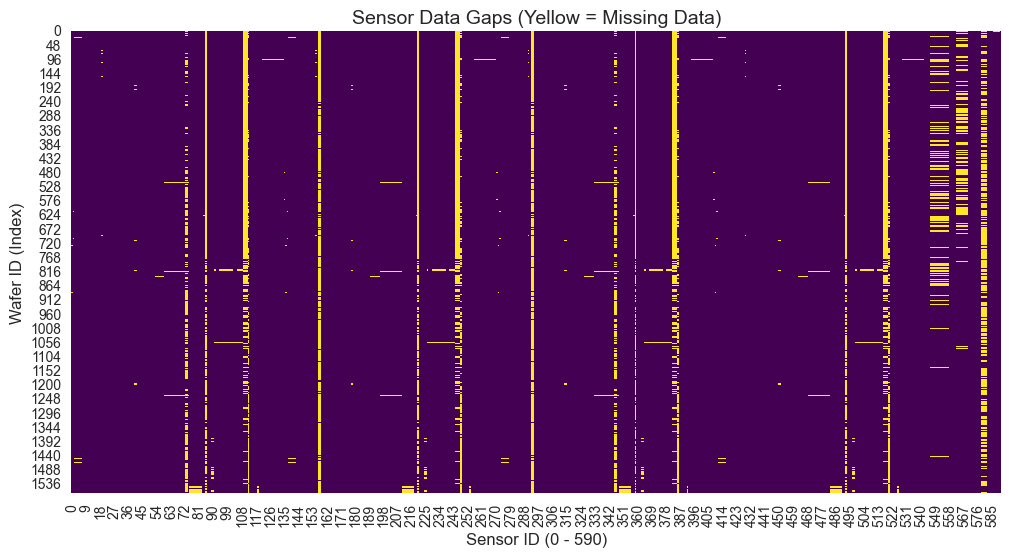

In [11]:
"""
Exploratory Analysis - Step 2
Objective: Visualizing Sensor Data Quality (Missing Values)

Real-world sensor data is rarely perfect. Sensors may go offline, fail to log,
or log NaNs (Not a Number) during maintenance cycles.

We use a Heatmap to visualize the "sparsity" of the data matrix.
- X-axis: The 590 Sensors
- Y-axis: The 1567 Wafers
- Color: Yellow indicates MISSING data. Purple indicates GOOD data.
"""

# Increase the figure size so we can actually see the details
plt.figure(figsize=(12, 6))

# sns.heatmap arguments:
# - df.isnull(): Creates a matrix of True (Missing) and False (Present)
# - cbar=False: Turn off the color bar legend (we just want the pattern)
# - cmap='viridis': A high-contrast color map (Yellow/Purple)
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')

plt.title("Sensor Data Gaps (Yellow = Missing Data)", fontsize=14)
plt.xlabel("Sensor ID (0 - 590)", fontsize=12)
plt.ylabel("Wafer ID (Index)", fontsize=12)

# Show the plot
plt.show()

# CONSULTANT'S OBSERVATION:
# You should see distinct vertical "stripes" of yellow.
# These represent specific sensors that are broken or disconnected for
# almost the entire production run. These features contain no information
# and must be dropped before modeling.

In [12]:
"""
Exploratory Analysis - Step 3
Objective: Data Cleaning & Feature Selection

Strategy:
1. "Null Check": Remove sensors that are empty for >50% of the wafers.
2. "Flatline Check": Remove sensors that have 0 variance (same value for every wafer).
3. "Imputation": Fill small remaining gaps with the mean value.
"""

# --- STEP 1: REMOVE HIGH-MISSING COLUMNS ---
# limit: The threshold. If a column has more than 50% NaNs, it gets cut.
limit = 0.5 * len(df)
df_clean = df.dropna(axis=1, thresh=limit)

print(f"🧹 High-Missing Filter:")
print(f"   - Original Sensor Count: {df.shape[1]}")
print(f"   - Sensors Remaining: {df_clean.shape[1]}")
print(f"   - Dropped {df.shape[1] - df_clean.shape[1]} sensors due to missing data.")


# --- STEP 2: REMOVE FLATLINE SENSORS (ZERO VARIANCE) ---
# Some sensors might exist but just read "0" or "42" for every single wafer.
# These provide zero information for the model.

# nunique() counts the number of unique values in a column.
# If nunique == 1, that means the sensor never changed value.
nunique = df_clean.nunique()
cols_to_drop = nunique[nunique == 1].index

df_clean = df_clean.drop(cols_to_drop, axis=1)

print(f"\n📉 Flatline Filter:")
print(f"   - Sensors Remaining: {df_clean.shape[1]}")
print(f"   - Dropped {len(cols_to_drop)} sensors because they were constant/flat.")


# --- STEP 3: IMPUTE REMAINING MISSING VALUES ---
# We still have small gaps (holes) in the data. We must fill them to run ML models.
# A standard engineering approach is "Mean Imputation" (fill with the average).

# Note: We fill using the mean of the column
df_clean = df_clean.fillna(df_clean.mean())

print(f"\n✅ Final Dataset Ready:")
print(f"   - Wafers: {df_clean.shape[0]}")
print(f"   - Valid Sensors: {df_clean.shape[1] - 1}") # Subtract target column

# Save the clean version for the next phase (Modeling)
df_clean.to_csv("../clean_wafer_data.csv", index=False)
print("💾 Saved cleaned data to '../clean_wafer_data.csv'")

🧹 High-Missing Filter:
   - Original Sensor Count: 591
   - Sensors Remaining: 563
   - Dropped 28 sensors due to missing data.

📉 Flatline Filter:
   - Sensors Remaining: 447
   - Dropped 116 sensors because they were constant/flat.

✅ Final Dataset Ready:
   - Wafers: 1567
   - Valid Sensors: 446
💾 Saved cleaned data to '../clean_wafer_data.csv'


🤖 Training Random Forest to rank sensors... (This may take 10-20 seconds)

🏆 Top 10 Most Critical Sensors:
   1. Sensor 59 (Importance: 0.0297)
   2. Sensor 130 (Importance: 0.0131)
   3. Sensor 103 (Importance: 0.0128)
   4. Sensor 33 (Importance: 0.0080)
   5. Sensor 341 (Importance: 0.0080)
   6. Sensor 287 (Importance: 0.0075)
   7. Sensor 519 (Importance: 0.0070)
   8. Sensor 64 (Importance: 0.0068)
   9. Sensor 348 (Importance: 0.0068)
   10. Sensor 65 (Importance: 0.0067)


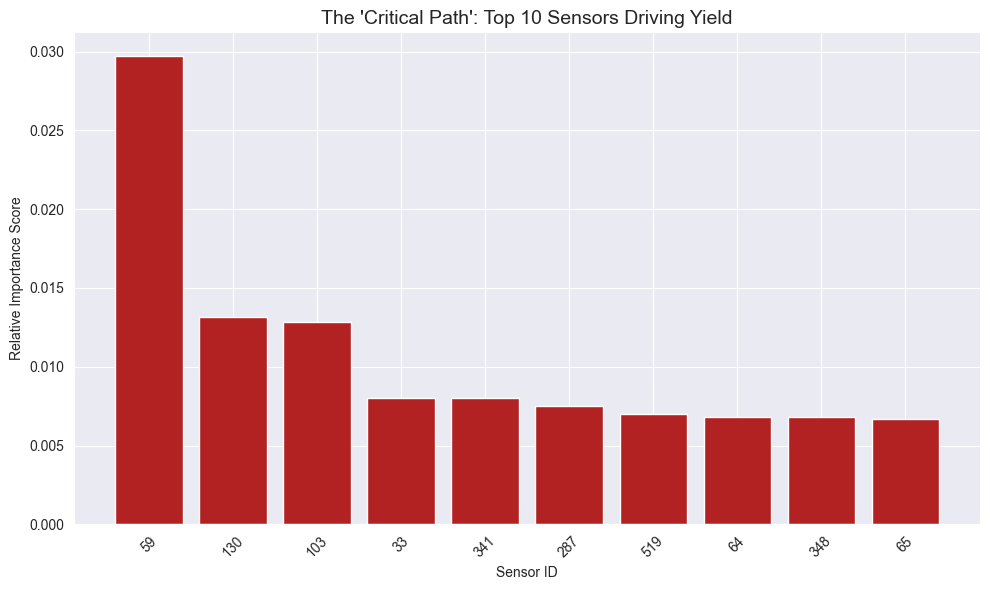

In [13]:
"""
Exploratory Analysis - Step 4
Objective: Identify the "Critical Path" Sensors using Random Forest

We have 446 sensors. Which ones actually drive the failures?
We train a Random Forest Classifier. This model naturally ranks features
based on how much they decrease "impurity" (i.e., how well they split
Pass vs. Fail wafers).
"""

from sklearn.ensemble import RandomForestClassifier
import numpy as np

# --- STEP 1: PREPARE THE DATA ---
# Separate Features (X) from Target (y)
X = df_clean.drop('Target', axis=1)
y = df_clean['Target']

# --- STEP 2: TRAIN THE MODEL ---
# We use a Random Forest with 100 trees.
# random_state=42 ensures we get the same result every time we run it.
# class_weight='balanced' is CRITICAL because we have so few failures (6%).
# It tells the model: "Pay 10x more attention to a Failure than a Pass."
print("🤖 Training Random Forest to rank sensors... (This may take 10-20 seconds)")
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X, y)


# --- STEP 3: EXTRACT & PLOT IMPORTANCE ---
# The model has a .feature_importances_ attribute: an array of scores summing to 1.
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1] # Sort huge to small

# Let's look at the Top 10 Sensors
top_n = 10
top_indices = indices[:top_n]
top_scores = importances[top_indices]
top_sensor_names = X.columns[top_indices]

print(f"\n🏆 Top {top_n} Most Critical Sensors:")
for i, (name, score) in enumerate(zip(top_sensor_names, top_scores)):
    print(f"   {i+1}. Sensor {name} (Importance: {score:.4f})")

# Visualization
plt.figure(figsize=(10, 6))
plt.title("The 'Critical Path': Top 10 Sensors Driving Yield", fontsize=14)
plt.bar(range(top_n), top_scores, color='firebrick', align='center')
plt.xticks(range(top_n), top_sensor_names, rotation=45)
plt.ylabel("Relative Importance Score")
plt.xlabel("Sensor ID")
plt.tight_layout()
plt.show()

# CONSULTANT'S OBSERVATION:
# The sensor at the far left (Rank #1) is your "Smoking Gun."
# It has the highest predictive power for yield failure.
# In a client presentation, this is the first thing you point to.

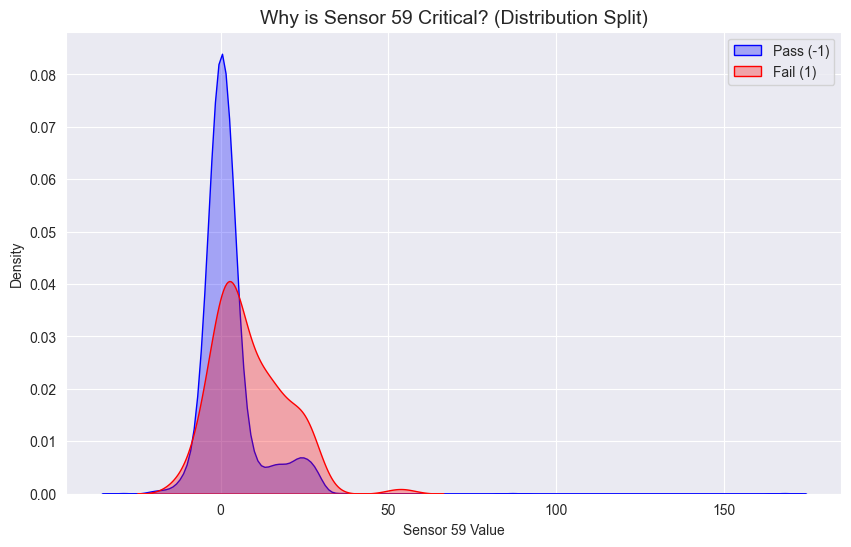

In [14]:
"""
Exploratory Analysis - Step 5
Objective: Deep Dive into the Top Suspect (Sensor 59)

We know Sensor 59 is important. Now we need to know WHY.
We will overlay two histograms:
1. Blue: The values of Sensor 59 for GOOD wafers (Pass).
2. Red: The values of Sensor 59 for BAD wafers (Fail).

This will show us the "Zone of Failure."
"""

# Get the name of the #1 sensor (index 0 in our sorted list)
top_sensor = top_sensor_names[0]

plt.figure(figsize=(10, 6))

# Plot the "Pass" wafers in Blue
sns.kdeplot(df_clean.loc[df_clean['Target'] == -1, top_sensor],
            label='Pass (-1)', color='blue', fill=True, alpha=0.3)

# Plot the "Fail" wafers in Red
sns.kdeplot(df_clean.loc[df_clean['Target'] == 1, top_sensor],
            label='Fail (1)', color='red', fill=True, alpha=0.3)

plt.title(f"Why is Sensor {top_sensor} Critical? (Distribution Split)", fontsize=14)
plt.xlabel(f"Sensor {top_sensor} Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# CONSULTANT'S OBSERVATION:
# Look at the Red curve. Does it shift to the left (Low values cause failure)?
# Or shift to the right (High values cause failure)?
# Or does it have a "long tail"?
# This tells the Process Engineer exactly how to set the alarm limits.

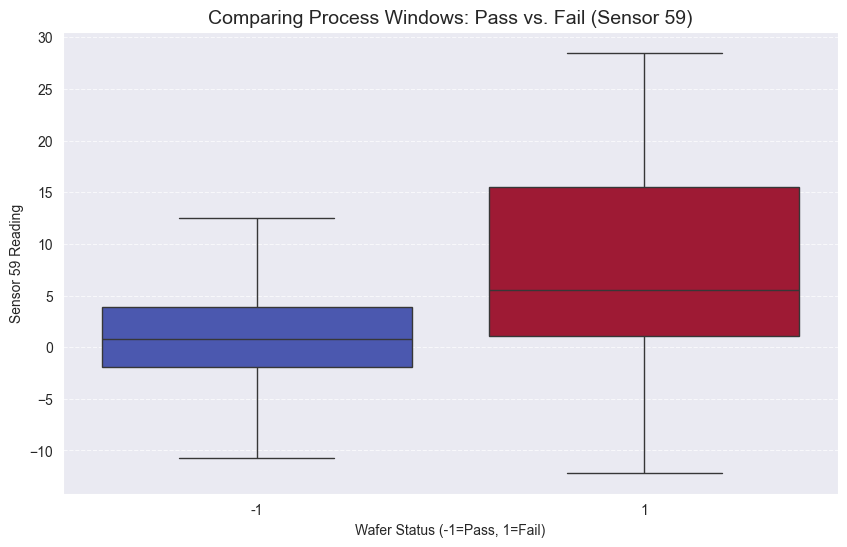

📊 Statistics for Sensor 59:
   - Average Reading for GOOD Wafers: 2.5654
   - Average Reading for BAD Wafers:  8.5151
   - Delta: 5.9498 units higher on average.


In [15]:
"""
Exploratory Analysis - Step 6
Objective: Define the "Safe Operating Limit" (Box Plot)

We identified that High Values on Sensor 59 cause failures.
We need to visualize the "Spread" and "Outliers" to recommend a specific limit.

The Box Plot shows:
- The Box: The middle 50% of the data (The "Core Process")
- The Line in the middle: The Median
- The Whiskers: The range of "Normal" data
- The Diamonds: Outliers (Statistical anomalies)
"""

plt.figure(figsize=(10, 6))

# The "One-Liner" that beats Excel (Updated for Seaborn v0.14+):
# hue='Target': Explicitly tells Seaborn to color based on Pass/Fail status
# legend=False: We don't need a separate legend since the X-axis labels explain it
sns.boxplot(x='Target', y=top_sensor, data=df_clean, hue='Target', palette="coolwarm", legend=False, showfliers=False)

plt.title(f"Comparing Process Windows: Pass vs. Fail (Sensor {top_sensor})", fontsize=14)
plt.xlabel("Wafer Status (-1=Pass, 1=Fail)")
plt.ylabel(f"Sensor {top_sensor} Reading")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# CONSULTANT'S CALCULATION:
# We calculate the summary stats to put hard numbers in our report.
pass_mean = df_clean[df_clean['Target'] == -1][top_sensor].mean()
fail_mean = df_clean[df_clean['Target'] == 1][top_sensor].mean()

print(f"📊 Statistics for Sensor {top_sensor}:")
print(f"   - Average Reading for GOOD Wafers: {pass_mean:.4f}")
print(f"   - Average Reading for BAD Wafers:  {fail_mean:.4f}")
print(f"   - Delta: {fail_mean - pass_mean:.4f} units higher on average.")